# Style transfer using VGG16 network

In [1]:
#import sys
#sys.path.append("$HOME/models/research/slim/")

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters setting

In [2]:
image_size = L = 224
noise_ratio = 0.6
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
content_weight = 0.01
style_weight = 1.0
learning_rate = 0.01
max_steps = 500

### Load a VGG16 graph

In [3]:
from nets import vgg

In [4]:
# 여기를 직접 채워 넣으시면 됩니다.
content_image = tf.placeholder()
style_image = tf.placeholder()
initial_image = tf.get_variable()

initial_image_op1 = initial_image.assign(initial_image * noise_ratio)
initial_image_op2 = initial_image.assign_add(content_image * (1.0 - noise_ratio))
generated_image = initial_image

In [5]:
# 여기를 직접 채워 넣으시면 됩니다.
with tf.variable_scope() as scope:
  _, feature_maps_c = vgg.vgg_16(content_image,
                                 num_classes=None,
                                 is_training=False)
  _, feature_maps_s = vgg.vgg_16(style_image,
                                 num_classes=None,
                                 is_training=False)
  _, feature_maps_g = vgg.vgg_16(generated_image,
                                 num_classes=None,
                                 is_training=False)

In [6]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/01_style_transfer", sess.graph)
  writer.close()

## Build a model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg16/vgg_16/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg16/vgg_16/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg16/vgg_16/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg16/vgg_16/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg16/vgg_16/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg16/vgg_16/conv5/conv5_1'

In [7]:
content_layers = feature_maps_c['vgg_16/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_16/conv1/conv1_1'],
                feature_maps_s['vgg_16/conv2/conv2_1'],
                feature_maps_s['vgg_16/conv3/conv3_1'],
                feature_maps_s['vgg_16/conv4/conv4_1'],
                feature_maps_s['vgg_16/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_16/conv4/conv4_2'],
                    feature_maps_g['vgg_16/conv1/conv1_1'],
                    feature_maps_g['vgg_16/conv2/conv2_1'],
                    feature_maps_g['vgg_16/conv3/conv3_1'],
                    feature_maps_g['vgg_16/conv4/conv4_1'],
                    feature_maps_g['vgg_16/conv5/conv5_1']]

### content loss

In [8]:
def content_loss(P, F, scope):
  """Calculate the content loss function between
  the feature maps of content image and generated image.
  
  Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: content loss (mean squared loss)
  """
  # 여기를 직접 채워 넣으시면 됩니다.
  loss = 
  return loss

### style loss

In [9]:
def style_loss(style_layers, generated_layers, scope):
  """Calculate the style loss function between
  the gram matrix of feature maps of style image and generated image.
  
  Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: style loss (mean squared loss)
  """
  def _style_loss_one_layer(feature_map_s, feature_map_g):
    """Calculate the style loss for one layer.
    
    Args:
      feature_map_s: the feature map of the style image
        - G: the gram matrix of the feature_map_s
      feature_map_g: the feature map of the generated image
        - A: the gram matrix of the feature_map_g
      
    Returns:
      loss: style loss for one layer (mean squared loss)
    """
    assert feature_map_s.shape == feature_map_g.shape
    _, h, w, c = feature_map_s.get_shape().as_list()
    G = _gram_matrix(feature_map_s)
    A = _gram_matrix(feature_map_g)
    # 여기를 직접 채워 넣으시면 됩니다.
    return 
  
  def _gram_matrix(feature_map):
    """Calculate the gram matrix for the feature map
    
    Args:
      feature_map: 4-rank Tensor [1, height, width, channels]
        - F = 2-rank Tensor [h * w, channels]
      
    Returns:
      gram_matrix: 2-rank Tensor [c, c] (F * F.transpose)
    """
    # 여기를 직접 채워 넣으시면 됩니다.
    F = tf.squeeze()
    h, w, c = F.shape
    F = tf.reshape()
    return 
    
    
  assert len(style_layers) == len(generated_layers)
  
  loss = 0.0
  for i in range(len(style_layers)):
    loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
    loss += loss_one * style_loss_weight[i]

  return loss * 0.25

### Total loss

In [10]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss')
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss')

with tf.variable_scope('total_loss'):
  total_loss = content_weight * loss_c + style_weight * loss_s

### Define a optimizer

In [11]:
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss,
                                                                        var_list=[generated_image])

### Restore VGG16 weights using `tf.saver.restore`

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='../checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ mv vgg_16_2016_08_28.tar.gz ${CHECKPOINT_DIR}
$ rm vgg_16_2016_08_28.tar.gz
```

### Read a image

In [12]:
def image_preprocessing(image):
  """image preprocessing

  Args:
    image: PIL image format
  
  Returns:
    image: resized image with numpy array type [1, h, w, 3]
  """
  image = image.resize((L, L))
  image = np.asarray(image) / 255.
  image -= 0.5
  image *= 2.0

  image = np.expand_dims(image, axis=0)
  return image 

In [13]:
content_image_ = Image.open('../input_data/my_cat1.jpg')
style_image_ = Image.open('../input_data/Starry_Night.jpg')

content_image_ = image_preprocessing(content_image_)
style_image_ = image_preprocessing(style_image_)

In [15]:
def print_generated_image(generated_image):
  """print generated image
  
  Args:
    generated_image: 4-rank np.array [1, h, w, 3]
  """
  print_image = np.squeeze(generated_image, axis=0)
  max_ = np.max(print_image)
  min_ = np.min(print_image)
  print(max_, min_)
  print_image -= min_
  print_image /= max_ - min_
  plt.axis('off')
  plt.imshow(print_image)
  plt.show()

In [14]:
v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg_16')

1.0 -0.9764705882352941


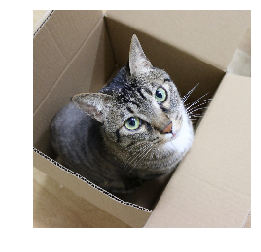

1.0 -1.0


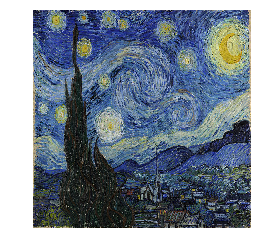

0.60995585 -0.58248425


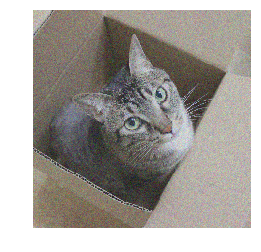

INFO:tensorflow:Restoring parameters from ../checkpoints/vgg_16.ckpt
step: 0  loss: 475021.09375  duration: 1.5035691261291504
0.60995585 -0.58248425


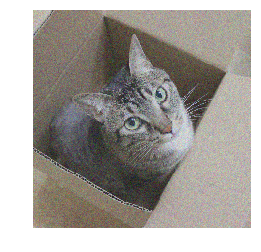

step: 50  loss: 23853.892578125  duration: 0.01848626136779785
0.81349504 -0.7292499


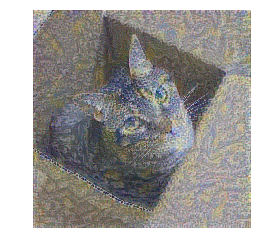

step: 100  loss: 15337.6884765625  duration: 0.01832270622253418
0.98990947 -0.63891107


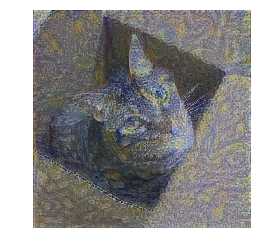

step: 150  loss: 11709.4638671875  duration: 0.01853775978088379
1.0990374 -0.65538216


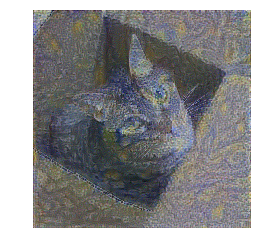

step: 200  loss: 9343.1494140625  duration: 0.018551111221313477
1.1925685 -0.7289077


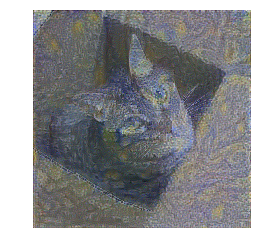

step: 250  loss: 7596.00341796875  duration: 0.018486499786376953
1.3539798 -0.7085024


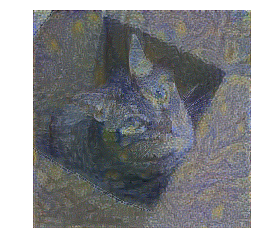

step: 300  loss: 6242.36474609375  duration: 0.018543243408203125
1.5078316 -0.6944277


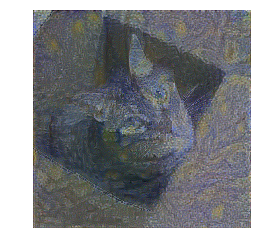

step: 350  loss: 5163.7841796875  duration: 0.018522024154663086
1.6031437 -0.6815509


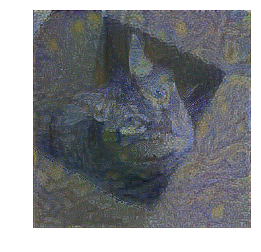

step: 400  loss: 4292.52783203125  duration: 0.01860642433166504
1.6748822 -0.65461254


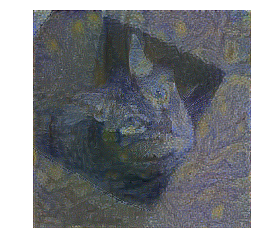

step: 450  loss: 3579.291748046875  duration: 0.018596887588500977
1.7339354 -0.6774687


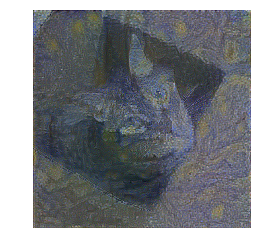

step: 500  loss: 2993.11181640625  duration: 0.01840519905090332
1.7651174 -0.70437443


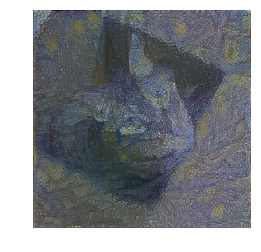

training done!


In [16]:
saver = tf.train.Saver(var_list=v)

with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  sess.run([initial_image_op1,
            initial_image_op2], feed_dict={content_image: content_image_})

  generated_image_ = sess.run(generated_image)
  print_generated_image(content_image_)
  print_generated_image(style_image_)
  print_generated_image(generated_image_)

  # use saver object to load variables from the saved model
  saver.restore(sess, "../checkpoints/vgg_16.ckpt")
  
  for step in range(max_steps+1):
    start_time = time.time()
    _, loss_, generated_image_ = \
        sess.run([train_op, total_loss, generated_image],
                 feed_dict={content_image: content_image_,
                            style_image: style_image_})
    if step % 50 == 0:
      duration = time.time() - start_time
      print("step: {}  loss: {}  duration: {}".format(step,
                                                      loss_,
                                                      duration))
      print_generated_image(generated_image_)
  print('training done!')